In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
import math
import uncertainties as u
import uncertainties.unumpy as unp

In [4]:
frame_potential = np.load('/home/minzhao.liu/Frame_Potential/results/PRU/frame_potential.npy')
#frame_potential = np.load('/lcrc/project/perfopt/minzhao.liu/Frame_Potential/results/barren_plateau/combined/frame_potential.npy')

max_ns = 48
min_ns = 4
qubit_increment = 2
max_l = 14
min_l = 1
max_k = 4
x = np.linspace(min_l, max_l, num=max_l+1-min_l)

/home/minzhao.liu/.conda/envs/analysis/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/minzhao.liu/.conda/envs/analysis/lib/python3.9/site-packages/uncertainties/core.py:186: RuntimeWarning: invalid value encountered in true_divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


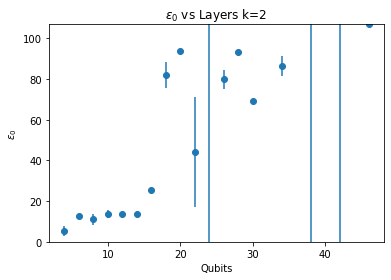

[6.91978669]


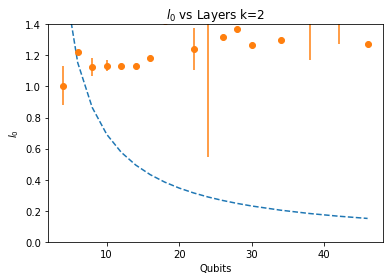

/home/minzhao.liu/.conda/envs/analysis/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/minzhao.liu/.conda/envs/analysis/lib/python3.9/site-packages/uncertainties/core.py:186: RuntimeWarning: invalid value encountered in true_divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


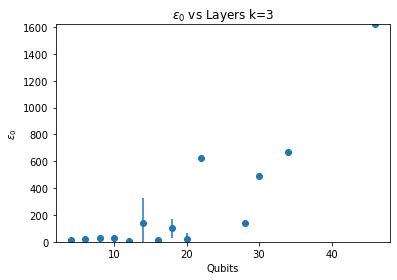

[6.17728212]


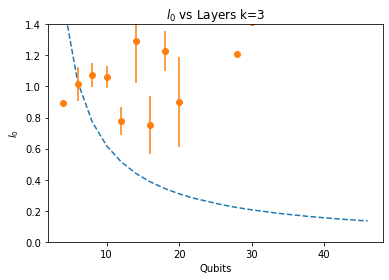

/home/minzhao.liu/.conda/envs/analysis/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/minzhao.liu/.conda/envs/analysis/lib/python3.9/site-packages/uncertainties/core.py:186: RuntimeWarning: invalid value encountered in true_divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


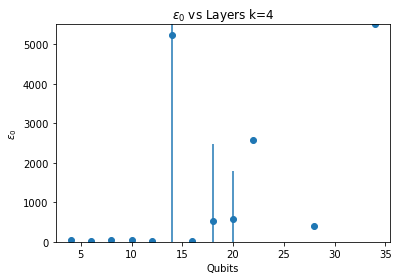

[6.42291525]


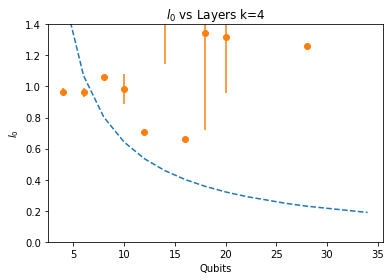

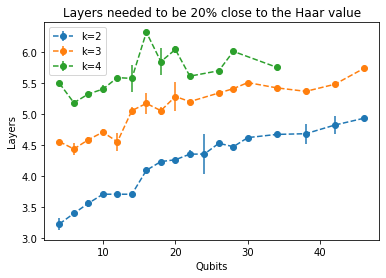

In [19]:
def EXP(x, m, t):
    return m * np.exp(-t * x)

def inv(x, a):
    return a/x

max_ns = 48
min_ns = 4
qubit_increment = 2
max_l = 14
min_l = 1
max_k = 4
min_k = 2

xs2 = np.linspace(2,13,36)

all_ums = []
all_uts = []
all_uls = []
all_ns = []

for k in range(min_k,max_k+1):
    haar = math.factorial(k)
    k_data = frame_potential[:, :, k-1]/haar
    params = None
    k_all_ns = []
    all_params = []
    for n in range(min_ns, max_ns+1, qubit_increment):
        n_data = k_data[n-1]
        try:
            if ~np.all(np.isnan(n_data)):
                first_l = None
                last_l = None
                for l in range(max_l):
                    mean = n_data[l, 0]-1
                    std = n_data[l, 1]
                    if (first_l == None) and (mean <= 1):
                        first_l = l
                    if (mean + 2*std < 0.1):
                        last_l = l
                        break
                if last_l == None:
                    last_l = first_l+1
                xs =  np.arange(last_l+1-first_l) + first_l
                ys = n_data[first_l:last_l+1, 0] - 1
                sigmas = n_data[first_l-1:last_l, 1]

                fix_init = False
                if fix_init:
                    nEXP = lambda x, t: EXP(x, 2**n, t)
                    params, cv = op.curve_fit(nEXP, xs, ys, sigma=sigmas, p0=params)
                    sampleRate = 20_000 # Hz
                    tauSec = (1 / params) / sampleRate
                    ys2B = EXP(xs2, 2**n, params)
                    plt.errorbar(xs, ys, yerr=sigmas, fmt='.', label="data")
                    plt.plot(xs, ys, '.', label='data')
                    plt.plot(xs2, ys2B, '--', label="zero B")
                else:
                    params, cv = op.curve_fit(EXP, xs, ys, sigma=sigmas, p0=params)
                    uparams = u.correlated_values(params, cv)
                    all_params.append(uparams)
                    m, t = params
                    sampleRate = 20_000 # Hz
                    tauSec = (1 / t) / sampleRate
                    ys2B = EXP(xs2, m, t)
                    #plt.errorbar(xs, ys, yerr=sigmas, fmt='.', label="data")
                    #plt.plot(xs, ys, '.', label='data')
                    #plt.plot(xs2, ys2B, '--', label="zero B")
                k_all_ns.append(n)
        except:
            pass
            
    #plt.yscale('log')
    #plt.ylim(0.01,1)
    #plt.ylim(haar,haar*2)
    #plt.rcParams["figure.figsize"] =  (10,6)
    #plt.show()

    all_params = np.array(all_params)
    k_all_ns = np.array(k_all_ns)
    all_ns.append(k_all_ns)
    um = all_params[:,0]
    ut = all_params[:,1]
    ul = (-1/ut)*unp.log(0.2/um)
    all_ums.append(um)
    all_uts.append(ut)
    all_uls.append(ul)

    plt.errorbar(k_all_ns, unp.nominal_values(um), yerr=unp.std_devs(um), fmt='o')
    plt.ylim(0,unp.nominal_values(um)[-1])
    plt.xlabel('Qubits')
    plt.ylabel('$\epsilon_0$')
    plt.title('$\epsilon_0$ vs Layers k={}'.format(k))
    plt.savefig('epsilon_0 vs Layers k={}.pdf'.format(k))
    plt.show()

    a, var = op.curve_fit(inv, k_all_ns[:6], unp.nominal_values(ut)[:6])
    print(a)
    plt.plot(k_all_ns, inv(k_all_ns, a), '--')
    plt.errorbar(k_all_ns, unp.nominal_values(ut), yerr=unp.std_devs(ut), fmt='o')
    plt.ylim(0,1.4)
    plt.xlabel('Qubits')
    plt.ylabel('$l_0$')
    plt.title('$l_0$ vs Layers k={}'.format(k))
    plt.savefig('l_0 vs Layers k={}.pdf'.format(k))
    plt.show()
    #plt.plot(all_ns, unp.nominal_values(all_params))

for i in range(max_k-min_k+1):
    plt.errorbar(all_ns[i], unp.nominal_values(all_uls[i]), yerr=unp.std_devs(all_uls[i]), fmt='o', ls='--', label='k='+str(min_k+i))

#plt.ylim(0,13)
plt.xlabel('Qubits')
plt.ylabel('Layers')
plt.title('Layers needed to be 20% close to the Haar value')
plt.legend()
plt.savefig('Layers vs qubits.pdf')
plt.show()